# Estudo simples sobre a utilização do ARIMA para forecast de dados históricos 

## Esse notebook consiste em utilizar o modelo ARIMA nos dados de passegeiros de avião dos anos 1949 até 1960 e tentar prever quais serão os dados até 1990

In [ ]:
#Importando as bibliotecas 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date

In [ ]:
#Pegando os dados 
df = pd.read_csv("Data/AirPassengers.csv")

#Vendo os dados 
df.head()

In [ ]:
#Vendo o shape 
print("Linhas:{}\nColunas:{}".format(df.shape[0], df.shape[1]))

In [ ]:
#Vendo se há dados missing
df.isnull().sum()

In [ ]:
#Verificando o tipo dos dados 
df.dtypes

In [ ]:
#Passando o Month para data 
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
#Verificando novamento os dados
df.head()

In [ ]:
#Vendo a data mínima e máxima 
print("Data mais antiga: {}\nData mais recente: {}".format(df['Month'].min(), df['Month'].max()))

In [ ]:
#Criando a função para fazer o plot de linha sns
def plot_lineplot(data, x, y, titulo,color=None):
    plt.figure(figsize=(16,8))
    fig = sns.lineplot(data=data, x=x, y=y, color=color)
    fig.set_title(titulo)

In [ ]:
plot_lineplot(df, 'Month',"#Passengers", 'Passageiros durante todo o ano do dataframe')

In [ ]:
#Como podemos visualizar os dados são um conjunto de dados com sazonalidade 

#Isso muda a forma como iremos utilizar o ARIMA, que nesse caso é melhor a utilização do 
#SARIMAX que é o arima para dados sazonais 

In [ ]:
#Vamos fazer o a utilização da média móvel para conseguir visualizar melhor a tendência de crescimento dos dados 

In [ ]:
#Criando a rolling 
#Iremos utilizar o rolling de 12 dias já que nos dados estão presentes os 12 meses de cada ano
df['Media_movel'] = df['#Passengers'].rolling(12, center=False).mean()

#Vendo os dados 
df.head(13)

In [ ]:
#Usando a função de plotar para vermos os dois gráficos 
plot_lineplot(df, 'Month',"#Passengers", 'Passageiros durante todo o ano do dataframe', color='Lightgrey')
sns.lineplot(data=df[12:], x='Month', y='Media_movel', label="Média Móvel", color='Orange')

In [ ]:
#Podemos ver com clareza que mesmo com a sazonalidade ainda é possível visualizar a tendência de crescimento
#Do número de passageiros utilizando a média móvel

In [ ]:
#Realizar algumas funções para realizar a construção de parâmetros do ARIMA 

#Série estacionada
#IMportando bibliotecas
from statsmodels.tsa.stattools import adfuller

In [ ]:
#Salvar um y apenas com os dados crus e a data como indez 
#Colocando a data como index 
df.index = df['Month']

#Criando o y
y = df['#Passengers']
y.head()

In [ ]:
#USando o teste adfuller para indentificar a estacionaridade
print("Valor de P: {}".format(adfuller(y.dropna())[1]))

In [ ]:
#A série não é estacionária

In [ ]:
#Importando as bibliotecas de diferenciação e diferenciação parcial e autocirrelação
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot

In [ ]:
#Criando a função para plotar a diferenciação 
def ACF(y1,y2,y3):
    #Criando a figura 
    fig = plt.figure(figsize=(10,10))

    #Criando os subplots 
    ax1 = fig.add_subplot(311)
    fig = plot_acf(y1, ax=ax1, title="Original")
    ax2 = fig.add_subplot(312)
    fig = plot_acf(y2, ax=ax2, title="1º diferenciação'")
    ax3 = fig.add_subplot(313)
    fig = plot_acf(y3, ax=ax3, title="2º diferenciação")

In [ ]:
#Utilizando o gráfico para ver a diferencição 
ACF(y, y.diff().dropna(), y.diff().diff().dropna())

In [ ]:
#Vendo a alta correlação dos dados 
ax = plt.figure(figsize=(12,6))
autocorrelation_plot(y)

## Determinando valores para os parâmetros do ARIMA 

## Os parâmetros que precisamos definir são 
## P = Número de Lags
## D = Número de diferenciação 
## Q = Número da Média Móvel

In [ ]:
#Para conseguir identificar quais são os melhores valores da ordem para a utilização do ARIMA 
#Nós iremos fazer vários testes com múltiplos dados e pegar o Menor AIC das combinações 
#Depois de descobrir a ordem certa nós iremos fazer o teste de predição e posteriormente o forecast

In [ ]:
#Importando o itertools
import itertools

In [ ]:
#Colocando range das variáveis 

#Colocando a variável de p com o range de até 2 por conta do gráfico de autocorrelação
#Colocando a distância com o range de 0 a 1 também pelo fato de que mais de uma difer3enciação 
#Torna os dados over diferenciaded
p = d= range(0,2)

#Irei colocar o d como 0 a 12, pelo fato de que o tempo da média móvel qque precisamos usar é de 12 valores
#Por conta dos meses do ano 
q = range(0,13)

#Criando a lista de produtos 
pdq = list(itertools.product(p,d,q))


In [ ]:
#Vendo a lista 
pdq

In [ ]:
#Criando também a lista de pdpq possíveis para o SARIMAX
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

In [ ]:
#Printando como o teste seira
print("Os resultados da combinação de parâmetros para o SARIMAX")
print("SARIMAX: {} X {}".format(pdq[0], seasonal_pdq[0]))
print("SARIMAX: {} X {}".format(pdq[0], seasonal_pdq[1]))
print("SARIMAX: {} X {}".format(pdq[0], seasonal_pdq[2]))

In [ ]:
#Importando a bilbioteca onde se encontra o SARIMAX
import statsmodels.api as sm

In [ ]:
#Criando três listas para o futuro dataframe 
pdp_lista = []
seasonal_lista = []
aic_result = []

#Fazer o treinamento de todos os parâmetros
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal)

        #Fit do modelo 
        results = mod.fit()

        #Append das informações para o futuro dataframe 
        pdp_lista.append(param)
        seasonal_pdq.append(param_seasonal)
        aic_result.append(results.aic)

In [103]:
#Como o treinamento demora muito eu vou utilizar algumas ordem que talvez sejam uma opção 

In [105]:
#Criando o modelo SARIMAX para fit 
mod = sm.tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,12))

#Fit do modelo
results = mod.fit()

C:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


C:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


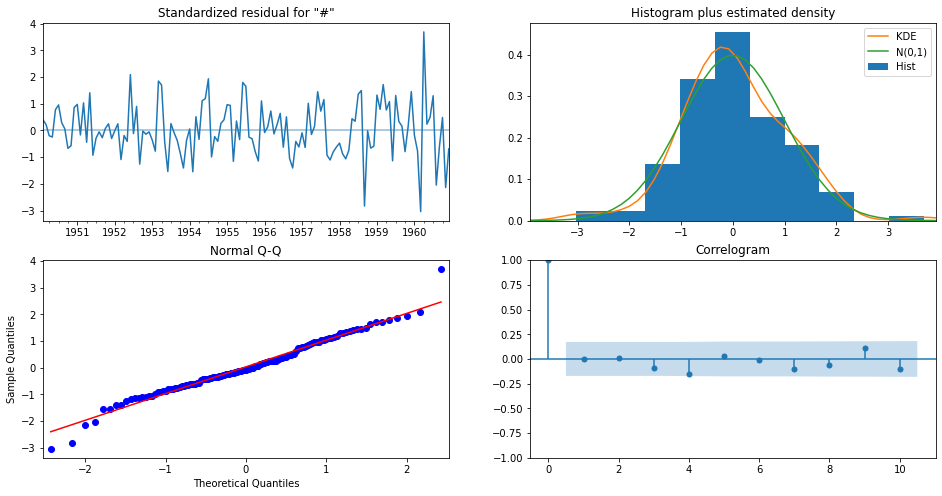

In [106]:
#Vendo os diagnóstics 
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [111]:
#Gerando as predições para um dado dentro do dataframe
pred = results.get_prediction(start=pd.to_datetime('1960-01-01'), dynamic=False)

#Pegando o intervalo de confiança 
pred_ic = pred.conf_int()

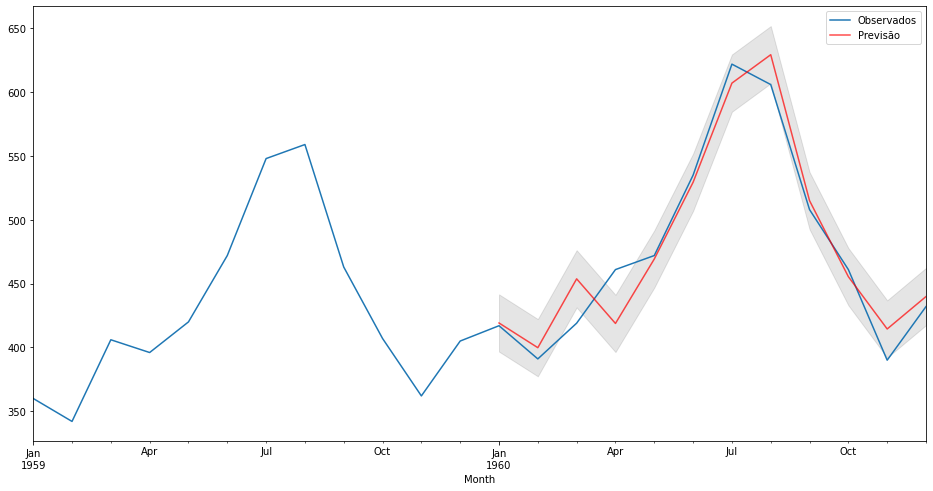

In [112]:
#Plotando o gráfico com os dados de teste e os dados de treino 
ax = y['1959':].plot(label="Observados")
pred.predicted_mean.plot(ax=ax, label="Previsão", color='r', alpha=0.7, figsize=(16,8))
ax.fill_between(pred_ic.index, pred_ic.iloc[:,0], pred_ic.iloc[:,1], color='k', alpha=0.1)
plt.legend()
plt.show()

In [113]:
#Como podemos ver o ARIMA conseguiu prever o aumento sazional no mês de jul e sua diminuição em outubro
#Agora iremos fazer o forecast 

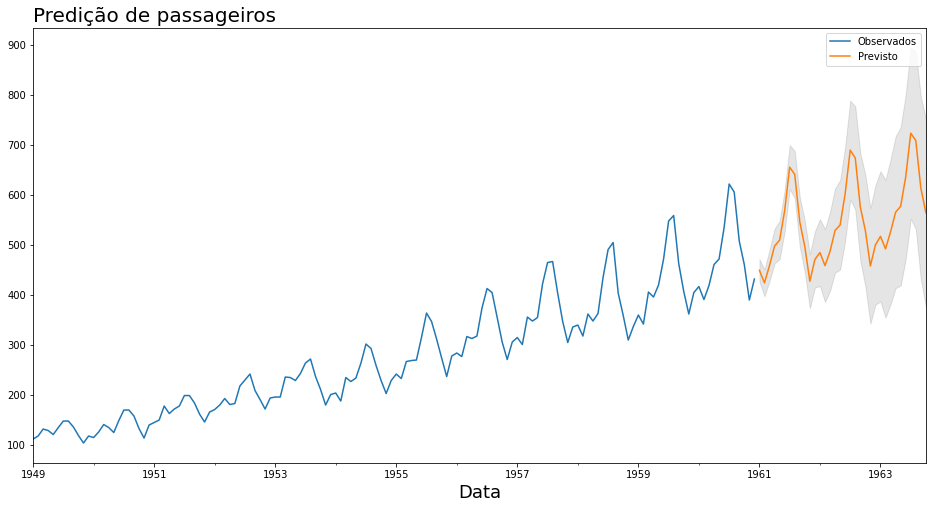

In [117]:
#Plotando o gráfico com o forecast dos dados 
pred_forecast = results.get_forecast(steps=34)
pred_ic = pred_forecast.conf_int()

#Plotando o gráfico 
ax = y.plot(label="Observados", figsize=(16,8))
pred_forecast.predicted_mean.plot(ax=ax, label='Previsto')
ax.fill_between(pred_ic.index, pred_ic.iloc[:,0], pred_ic.iloc[:,1], color='k', alpha=0.1)
plt.title("Predição de passageiros", loc='left', fontsize=20)
plt.xlabel("Data", fontsize=18)
plt.legend()
plt.show()